In [1]:
# load package
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import *

# load tool
from tool.help import SQLFormat

%matplotlib inline

In [2]:
db = "./data/northwind.sqlite3"
conn = sqlite3.connect(db)

## 背景
对数据库进行探索，发现表数据有：
```
Alphabetical list of products   Orders
Categories                      Orders Qry
Current Product List            Products
Customer and Suppliers by City  Products Above Average Price
CustomerCustomerDemo            Products by Category
CustomerDemographics            Region
Customers                       Shippers
EmployeeTerritories             Summary of Sales by Quarter
Employees                       Summary of Sales by Year
Order Details Extended          Suppliers
Order Subtotals                 Territories
OrderDetails
```
需要从以上的表数据中挖掘出以下信息**客户**、**供应商**、**产品**、**雇员**，并将相关信息尽心表达出来。我们将主要集中研究**客户**的角度进行分析

In [3]:
# display the tables
query = SQLFormat(conn)

## 查询客户基本信息
表 Custoemrs 包括了 `CustomerID`, `CompanyName`, `ContactName`, `ContactTitle`, `Address`, `City`, `Region`, `PostalCode`, `Country`, `Phone`, `Fax` 等字段。

* 客户的国家信息统计 客户来自于 USA, France, Germany, Brazil, UK, Mexico, Spain, Venezuela, Argentina, Canada, Italy, Austria, Belgium, Denmark, Finland, Portugal, Sweden, Switzerland, Ireland, Norway, Poland——按照对应国家数量从大到小进行了排序
* 客户联系人级别 直接通过 `SELECT DISTINCT` 查询，可知在联系人的级别上包括了 `Manager`, `Representative`, `Assistant` 以及 `Owner` 级别的用户

| ContactTitle                   |
| ------------------------------ |
| Sales Representative           |
| Owner                          |
| Order Administrator            |
| Marketing Manager              |
| Accounting Manager             |
| Sales Agent                    |
| Sales Associate                |
| Sales Manager                  |
| Marketing Assistant            |
| Assistant Sales Agent          |
| Assistant Sales Representative |
| Owner/Marketing Assistant      |

* 客户所属城市和国家相关信息 从整体上来看，超过一个用户的国家中，相关客户都是比较集中的。其中只有 Brazil 和 France 两个国家的客户分布在两个城市中

In [4]:
# Customers
customers = query.format("SELECT * FROM Customers;")

In [5]:
query_string = """
SELECT Country, COUNT(*) AS Amount
  FROM Customers
  GROUP BY 1
  ORDER BY 2 DESC;
"""
cust_country = query.format(query_string)

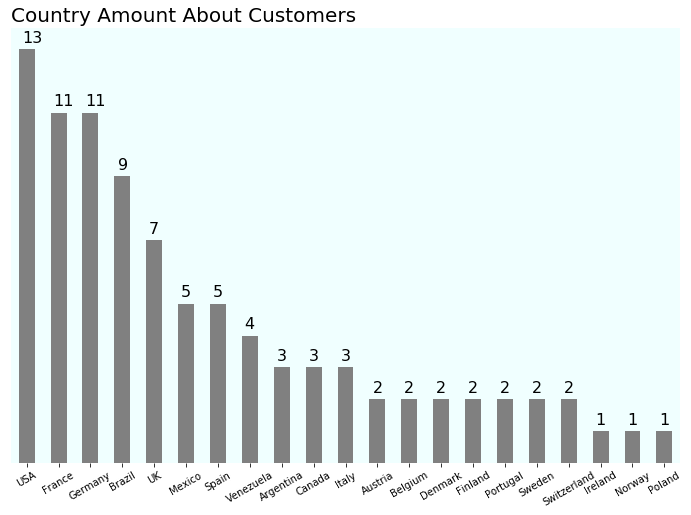

In [6]:
ax = plt.subplot()
cust_country.plot(
    kind="bar", x="Country", y="Amount", rot=30, figsize=(12, 8), legend=False,
    ax=ax, facecolor="grey"
)

ax.set_title("Country Amount About Customers", fontsize=20, loc="left")
ax.set_xlabel("")
ax.set_facecolor("azure")
ax.tick_params(axis="y", left=False, labelleft=False)
ax.tick_params(axis="x", labelsize=10)


for i in ["top", "bottom", "left", "right"]:
    ax.spines[i].set_visible(False)

for x, y in enumerate(cust_country.Amount.values):
    ax.text(x-.15, y+.2, "{:<2}".format(y), fontsize=16)

In [7]:
customers.head(2)

,CustomerID,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,None,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,None,05021,Mexico,(5) 555-4729,(5) 555-3745


In [8]:
# 客户联系人级别
query.format("SELECT DISTINCT ContactTitle FROM Customers;")

,ContactTitle
0,Sales Representative
1,Owner
2,Order Administrator
3,Marketing Manager
4,Accounting Manager
5,Sales Agent
6,Sales Associate
7,Sales Manager
8,Marketing Assistant
9,Assistant Sales Agent


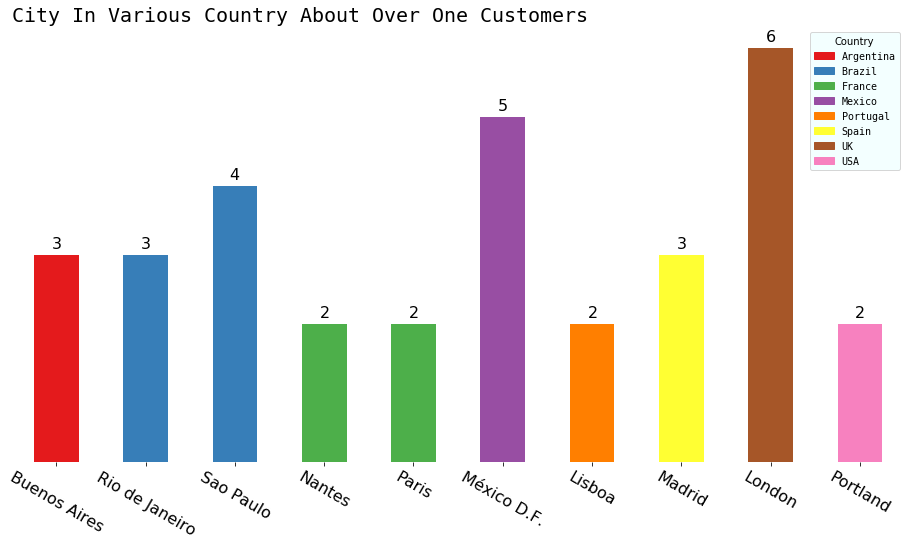

In [9]:
# 客户所属城市与国家情况
query_string = """
SELECT Country, City, COUNT(*) Amount
  FROM Customers
    GROUP BY 1, 2
    ORDER BY 1;
"""
data = query.format(query_string)
data = data[data.Amount > 1]
# get colors
colors = []
labels = []
handles = []
color_palette = sns.color_palette("Set1", n_colors=data.Country.nunique())
index = 0
for country1, country2 in zip(data.Country, data.Country.shift(-1)):
    if country2 == country1:
        colors.append(color_palette[index])
    else:
        labels.append(country1)
        handles.append(
        patches.Patch(color=color_palette[index], label=country1)
        )
        colors.append(color_palette[index])
        index += 1

# plot
plt.figure(figsize=(16, 8))
ax = plt.subplot()
data.plot(kind="bar", x="City", y="Amount", ax=ax, legend=False, color=colors, 
          rot=-30)

ax.tick_params(axis="y", left=False, labelleft=False)
ax.tick_params(axis="x", labelsize=16)
ax.set_title("City In Various Country About Over One Customers", loc="left", fontsize=20,
            family="monospace")
ax.set_xlabel("")
for x, y in enumerate(data.Amount.values):
    ax.text(x-.05, y+.1, "{:<2}".format(y), fontsize=16)

for i in ["top", "bottom", "left", "right"]:
    ax.spines[i].set_visible(False)
    
# legend
ax.legend(handles, labels, title="Country", loc="best", 
          facecolor="azure", framealpha=.8, prop={"family": "monospace"})
plt.show()

In [10]:
# query orders
query_string = """
SELECT *
  FROM Orders;
"""
orders = query.format(query_string)

In [11]:
orders.head(2)

,OrderId,CustomerID,EmployeeID,OrderDate,ShippedDate,RequiredDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2014-07-04,2014-07-16,2014-08-01,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France
1,10249,TOMSP,6,2014-07-05,2014-07-10,2014-08-16,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,None,44087,Germany


## 客户的订单信息分析
在了解了用户的基本信息之后，将分析客户在公司中的订单信息情况：
* 各客户总体的订单数量大部分的客户订单的总量上都是小于16，仅有很少的客户订单数量超过了 20。各国的客户订单数量和客户数量上表现出强相关性，线性相关系数达到了 $93.2\%$
* 分析客户第一笔订单的日期，从各年份的分布图可以知道用户的新增数量在降低

In [12]:
# query customers with orders
query_string = """
WITH CustomerOrders AS ( SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.Freight Freight, O.ShipCountry ShipCountry, c.CompanyName CompanyName, 
  c.City CustomerCity, c.Country CustomerCountry
    FROM Orders o
    LEFT JOIN Customers c
      ON o.CustomerID = c.CustomerID)

SELECT CustomerID, CustomerCountry, CustomerCity, COUNT(*) Amount 
  FROM CustomerOrders
    GROUP BY 1
    ORDER BY 2;
"""
customer_order = query.format(query_string)

In [13]:
customer_order.head(2)

,CustomerID,CustomerCountry,CustomerCity,Amount
0,CACTU,Argentina,Buenos Aires,6
1,OCEAN,Argentina,Buenos Aires,5


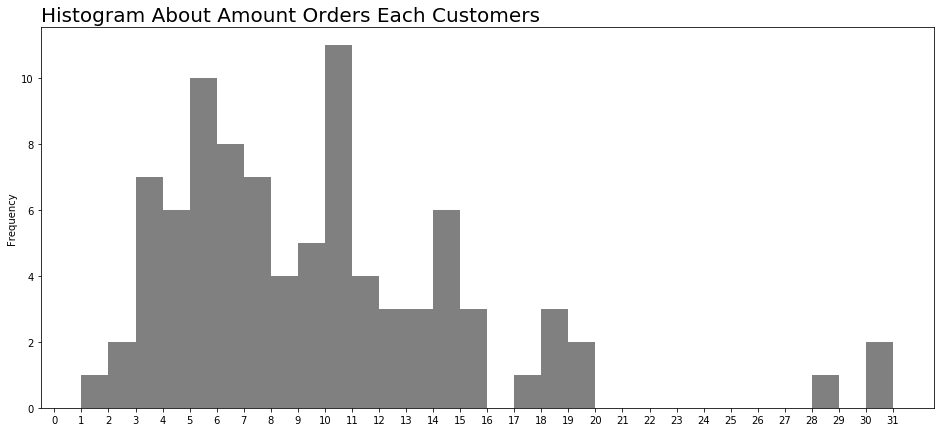

In [14]:
_, ax = plt.subplots()
customer_order.Amount.plot(kind="hist",figsize=(16, 7),bins=30, ax=ax, color="grey")
ax.set_title("Histogram About Amount Orders Each Customers", fontsize=20, loc="left")
plt.xticks(np.arange(0, 32), np.arange(0, 32))
plt.show()

In [15]:
data = cust_country.merge(
    customer_order.groupby("CustomerCountry")["Amount"].sum().reset_index(),
    left_on="Country", right_on="CustomerCountry"
)
data.drop("CustomerCountry", inplace=True, axis=1)
data.rename({"Amount_x":"CountryNumber", "Amount_y": "OrderAmount"},axis=1,
           inplace=True)

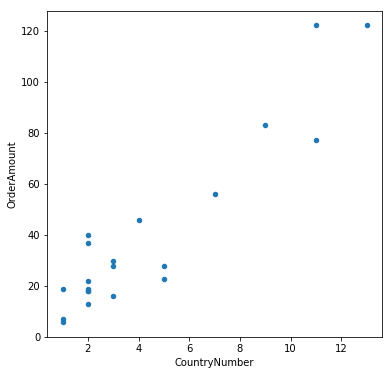

In [16]:
data[["CountryNumber", "OrderAmount"]].plot(kind="scatter", x="CountryNumber", 
                                            y="OrderAmount", figsize=(6, 6));

In [17]:
data[["CountryNumber", "OrderAmount"]].corr()

,CountryNumber,OrderAmount
CountryNumber,1.000000,0.932257
OrderAmount,0.932257,1.000000


In [18]:
# 查询各客户最早订单日期
query_string = """
SELECT CustomerID, OrderId, 
    MIN(OrderDate) Date, strftime('%Y', MIN(OrderDate)) Year 
  FROM Orders
    GROUP BY CustomerID 
    ORDER BY CustomerID;
"""
data = query.format(query_string)

In [19]:
data.head(3)

,CustomerID,OrderId,Date,Year
0,ALFKI,10643,2015-08-25,2015
1,ANATR,10308,2014-09-18,2014
2,ANTON,10365,2014-11-27,2014


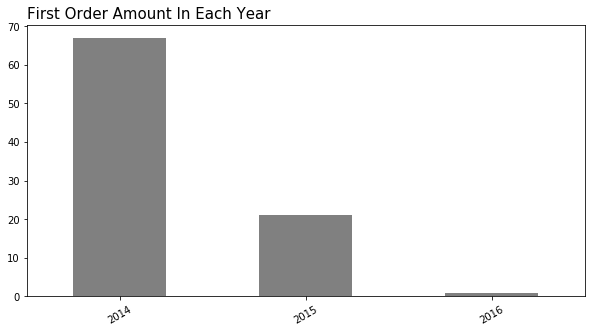

In [20]:
data.Year.value_counts().plot(kind="bar", color="grey", figsize=(10, 5), rot=30)
plt.title("First Order Amount In Each Year", loc="left", fontsize=15)
plt.show()

## 客户的订单产品信息分析
提取用户每个订单的的产品类型及数量、单价等信息统计分析。从以下信息进行分析：
* 订单的实际价值分布 从结果来看可知每张订单的价值主要都是低于 $2,500$，极少有订单超过 $5,000$。其中最小订单价值为 $12.5$
* 在用户订单信息中发现 Around the Horn 公司的所在城市（London）和收货地址不在同一个城市（Colchester）
* 总全年份来看，客户订单中每种产品类别的销售量变化中，只有饮料表现出整体的提高

In [21]:
query_string = """
WITH CustomerOrders AS ( SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.ShipCity ShipCity, o.ShipCountry ShipCountry, o.Freight Freight,
  c.CompanyName CompanyName, c.City CustomerCity, c.Country CustomerCountry
    FROM Orders o
      LEFT JOIN Customers c
    ON o.CustomerID = c.CustomerID
    ),

  OrderProducts AS (SELECT o.OrderId OrderId, o.ProductID ProductID,
  o.UnitPrice SaleUnitPrice, o.Quantity Quantity, o.Discount Discount,
  p.CategoryID CategoryID, p.UnitPrice OriginUnitPrice
    FROM OrderDetails o
      LEFT JOIN Products p
    ON o.ProductID = p.ProductID
    ),

  OrderProductDetail AS (SELECT o.OrderId OrderId, o.ProductID ProductID,
  o.SaleUnitPrice SaleUnitPrice, o.Quantity Quantity, o.Discount Discount,
  o.CategoryID CategoryID, o.OriginUnitPrice OriginUnitPrice, 
  c.CategoryName CategoryName
    FROM OrderProducts o
      LEFT JOIN Categories c
    ON o.CategoryID = c.CategoryID
  ),

  AllInfor AS (SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.ShipCity ShipCity, o.ShipCountry ShipCountry, o.Freight Freight,
  o.CompanyName CompanyName, o.CustomerCity CustomerCity, o.CustomerCountry CustomerCountry,
  c.ProductID ProductID, c.SaleUnitPrice OrderUnitPrice,c.Quantity OrderQuantity, 
  c.Discount Discount, c.CategoryID CategoryID,
  c.OriginUnitPrice OriginUnitPrice, c.CategoryName CategoryName
    FROM CustomerOrders o
      LEFT JOIN OrderProductDetail c
    ON o.OrderId = c.OrderID
)

SELECT OrderID, MAX(Total) Total
  FROM (SELECT OrderId,SUM(OrderUnitPrice * OrderQuantity) 
     OVER (PARTITION BY OrderID ORDER BY OrderUnitPrice * OrderQuantity) AS Total
    FROM AllInfor)
  GROUP BY OrderID;
"""
data = query.format(query_string)

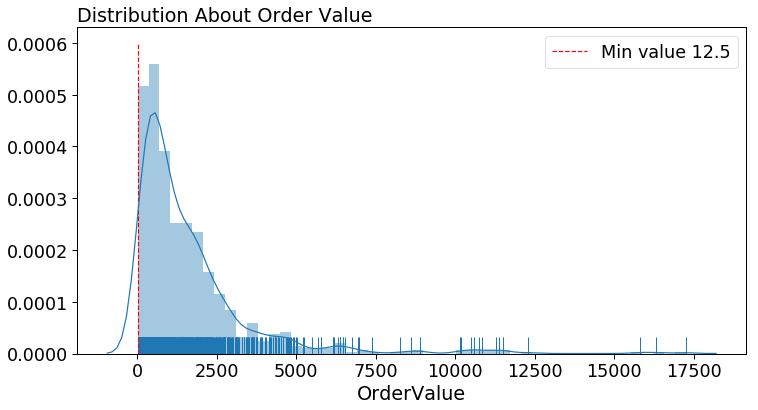

In [22]:
with sns.plotting_context("paper", font_scale=2):
    plt.figure(figsize=(12, 6))
    ax = plt.subplot()
    sns.distplot(data.Total, ax=ax, rug=True, axlabel="OrderValue")
    plt.title("Distribution About Order Value", loc="left")
    line = ax.vlines(data.Total.min(), 0, 0.0006, colors="red", linestyles="--",
              label="Min value %s" % data.Total.min())
    ax.legend()

In [23]:
query_string = """
WITH CustomerOrders AS ( SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.ShipCity ShipCity, o.ShipCountry ShipCountry, o.Freight Freight,
  c.CompanyName CompanyName, c.City CustomerCity, c.Country CustomerCountry
    FROM Orders o
      LEFT JOIN Customers c
    ON o.CustomerID = c.CustomerID
    ),

  OrderProducts AS (SELECT o.OrderId OrderId, o.ProductID ProductID,
  o.UnitPrice SaleUnitPrice, o.Quantity Quantity, o.Discount Discount,
  p.CategoryID CategoryID, p.UnitPrice OriginUnitPrice
    FROM OrderDetails o
      LEFT JOIN Products p
    ON o.ProductID = p.ProductID
    ),

  OrderProductDetail AS (SELECT o.OrderId OrderId, o.ProductID ProductID,
  o.SaleUnitPrice SaleUnitPrice, o.Quantity Quantity, o.Discount Discount,
  o.CategoryID CategoryID, o.OriginUnitPrice OriginUnitPrice, 
  c.CategoryName CategoryName
    FROM OrderProducts o
      LEFT JOIN Categories c
    ON o.CategoryID = c.CategoryID
  ),

  AllInfor AS (SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.ShipCity ShipCity, o.ShipCountry ShipCountry, o.Freight Freight,
  o.CompanyName CompanyName, o.CustomerCity CustomerCity, o.CustomerCountry CustomerCountry,
  c.ProductID ProductID, c.SaleUnitPrice OrderUnitPrice,c.Quantity OrderQuantity, 
  c.Discount Discount, c.CategoryID CategoryID,
  c.OriginUnitPrice OriginUnitPrice, c.CategoryName CategoryName
    FROM CustomerOrders o
      LEFT JOIN OrderProductDetail c
    ON o.OrderId = c.OrderID
)

SELECT *
  FROM AllInfor
  WHERE CustomerCity != ShipCity;
"""
query.format(query_string)

,OrderId,CustomerID,OrderDate,ShippedDate,RequiredDate,ShipCity,ShipCountry,Freight,CompanyName,CustomerCity,CustomerCountry,ProductID,OrderUnitPrice,OrderQuantity,Discount,CategoryID,OriginUnitPrice,CategoryName
0,10355,AROUT,2014-11-15,2014-11-20,2014-12-13,Colchester,UK,41.95,Around the Horn,London,UK,24,3.60,25,0.00,1,4.50,Beverages
1,10355,AROUT,2014-11-15,2014-11-20,2014-12-13,Colchester,UK,41.95,Around the Horn,London,UK,57,15.60,25,0.00,5,19.50,Grains/Cereals
2,10383,AROUT,2014-12-16,2014-12-18,2015-01-13,Colchester,UK,34.24,Around the Horn,London,UK,13,4.80,20,0.00,8,6.00,Seafood
3,10383,AROUT,2014-12-16,2014-12-18,2015-01-13,Colchester,UK,34.24,Around the Horn,London,UK,50,13.00,15,0.00,3,16.25,Confections
4,10383,AROUT,2014-12-16,2014-12-18,2015-01-13,Colchester,UK,34.24,Around the Horn,London,UK,56,30.40,20,0.00,5,38.00,Grains/Cereals
5,10453,AROUT,2015-02-21,2015-02-26,2015-03-21,Colchester,UK,25.36,Around the Horn,London,UK,48,10.20,15,0.10,3,12.75,Confections
6,10453,AROUT,2015-02-21,2015-02-26,2015-03-21,Colchester,UK,25.36,Around the Horn,London,UK,70,12.00,25,0.10,1,15.00,Beverages
7,10558,AROUT,2015-06-04,2015-06-10,2015-07-02,Colchester,UK,72.97,Around the Horn,London,UK,47,9.50,25,0.00,3,9.50,Confections
8,10558,AROUT,2015-06-04,2015-06-10,2015-07-02,Colchester,UK,72.97,Around the Horn,London,UK,51,53.00,20,0.00,7,53.00,Produce
9,10558,AROUT,2015-06-04,2015-06-10,2015-07-02,Colchester,UK,72.97,Around the Horn,London,UK,52,7.00,30,0.00,5,7.00,Grains/Cereals


In [24]:
query_string = """
WITH CustomerOrders AS ( SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.ShipCity ShipCity, o.ShipCountry ShipCountry, o.Freight Freight,
  c.CompanyName CompanyName, c.City CustomerCity, c.Country CustomerCountry
    FROM Orders o
      LEFT JOIN Customers c
    ON o.CustomerID = c.CustomerID
    ),

  OrderProducts AS (SELECT o.OrderId OrderId, o.ProductID ProductID,
  o.UnitPrice SaleUnitPrice, o.Quantity Quantity, o.Discount Discount,
  p.CategoryID CategoryID, p.UnitPrice OriginUnitPrice
    FROM OrderDetails o
      LEFT JOIN Products p
    ON o.ProductID = p.ProductID
    ),

  OrderProductDetail AS (SELECT o.OrderId OrderId, o.ProductID ProductID,
  o.SaleUnitPrice SaleUnitPrice, o.Quantity Quantity, o.Discount Discount,
  o.CategoryID CategoryID, o.OriginUnitPrice OriginUnitPrice, 
  c.CategoryName CategoryName
    FROM OrderProducts o
      LEFT JOIN Categories c
    ON o.CategoryID = c.CategoryID
  ),

  AllInfor AS (SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.ShipCity ShipCity, o.ShipCountry ShipCountry, o.Freight Freight,
  o.CompanyName CompanyName, o.CustomerCity CustomerCity, o.CustomerCountry CustomerCountry,
  c.ProductID ProductID, c.SaleUnitPrice OrderUnitPrice,c.Quantity OrderQuantity, 
  c.Discount Discount, c.CategoryID CategoryID,
  c.OriginUnitPrice OriginUnitPrice, c.CategoryName CategoryName
    FROM CustomerOrders o
      LEFT JOIN OrderProductDetail c
    ON o.OrderId = c.OrderID
)

SELECT CategoryName, Date, MAX(Total) Total
  FROM (SELECT OrderID, CategoryName, strftime("%Y-1-01", OrderDate) Date, 
      SUM(OrderUnitPrice * OrderQuantity) OVER (PARTITION BY CategoryName, 
          strftime("%Y-01-01", OrderDate) ORDER BY
          OrderUnitPrice * OrderQuantity) AS Total
      FROM AllInfor) Sub
  GROUP BY CategoryName, Date
"""
data = query.format(query_string)

In [25]:
data

,CategoryName,Date,Total
0,Beverages,2014-1-01,53879.20
1,Beverages,2015-1-01,110424.00
2,Beverages,2016-1-01,122223.75
3,Condiments,2014-1-01,19458.30
4,Condiments,2015-1-01,59679.00
5,Condiments,2016-1-01,34557.45
6,Confections,2014-1-01,31511.60
7,Confections,2015-1-01,87227.77
8,Confections,2016-1-01,58359.73
9,Dairy Products,2014-1-01,44615.80


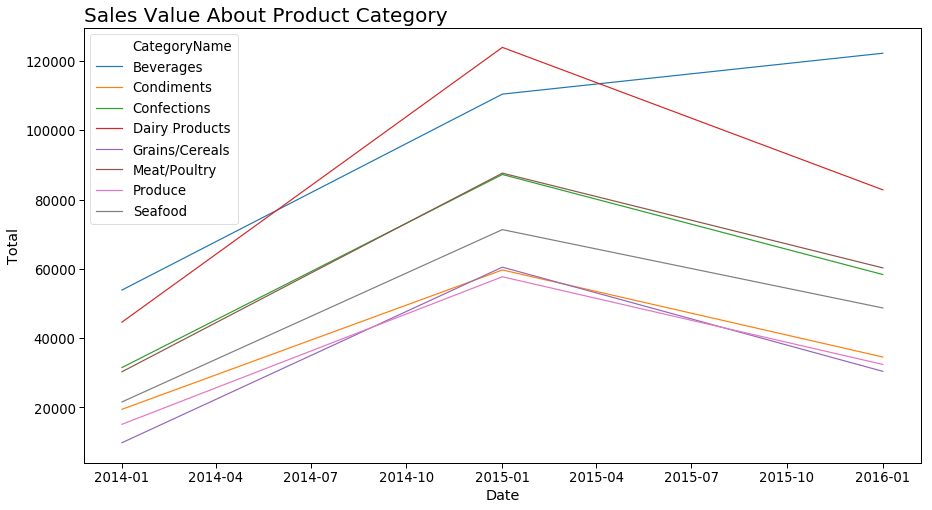

In [26]:
with sns.plotting_context("paper", font_scale=1.5):
    data["Date"] = pd.to_datetime(data.Date)
    plt.figure(figsize=(15, 8))
    ax = plt.subplot()
    sns.lineplot(x="Date", y="Total", hue="CategoryName", data=data, ax=ax)
    ax.set_title("Sales Value About Product Category", loc="left", fontsize=20)

In [27]:
# 销售物品中供货量最大供应商
query_string = """
WITH CustomerOrders AS ( SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.ShipCity ShipCity, o.ShipCountry ShipCountry, o.Freight Freight,
  c.CompanyName CompanyName, c.City CustomerCity, c.Country CustomerCountry
    FROM Orders o
      LEFT JOIN Customers c
    ON o.CustomerID = c.CustomerID
    ),

  OrderProducts AS (SELECT o.OrderId OrderId, o.ProductID ProductID,
  o.UnitPrice SaleUnitPrice, o.Quantity Quantity, o.Discount Discount,
  p.CategoryID CategoryID, p.UnitPrice OriginUnitPrice, p.SupplierID SupplierID
    FROM OrderDetails o
      LEFT JOIN Products p
    ON o.ProductID = p.ProductID
    ),

  OrderProductDetail AS (SELECT o.OrderId OrderId, o.ProductID ProductID,
  o.SaleUnitPrice SaleUnitPrice, o.Quantity Quantity, o.Discount Discount,
  o.CategoryID CategoryID, o.OriginUnitPrice OriginUnitPrice, o.SupplierID SupplierID,
  c.CategoryName CategoryName
    FROM OrderProducts o
      LEFT JOIN Categories c
    ON o.CategoryID = c.CategoryID
  ),

  AllInfor AS (SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.ShipCity ShipCity, o.ShipCountry ShipCountry, o.Freight Freight,
  o.CompanyName CompanyName, o.CustomerCity CustomerCity, o.CustomerCountry CustomerCountry,
  c.ProductID ProductID, c.SaleUnitPrice OrderUnitPrice,c.Quantity OrderQuantity, 
  c.Discount Discount, c.CategoryID CategoryID,c.SupplierID SupplierID,
  c.OriginUnitPrice OriginUnitPrice, c.CategoryName CategoryName
    FROM CustomerOrders o
      LEFT JOIN OrderProductDetail c
    ON o.OrderId = c.OrderID
    ),
    
  RawData AS (SELECT c.OrderId OrderId, c.CustomerID CustomerID,
  c.OrderDate OrderDate, c.ShippedDate ShippedDate, c.RequiredDate RequiredDate,
  c.ShipCity ShipCity, c.ShipCountry ShipCountry, c.Freight Freight,
  c.CompanyName BuyerCompanyName, c.CustomerCity CustomerCity, c.CustomerCountry CustomerCountry,
  c.ProductID ProductID, c.OrderUnitPrice OrderUnitPrice,c.OrderQuantity OrderQuantity, 
  c.Discount Discount, c.CategoryID CategoryID,c.SupplierID SupplierID,
  c.OriginUnitPrice OriginUnitPrice, c.CategoryName CategoryName, 
  s.CompanyName SupplierCompanyName
    FROM Allinfor c
      LEFT JOIN Suppliers s
    ON c.SupplierID = s.SupplierID)


SELECT CompanyName, MAX(TotalQuantity) MaxQuantity
  FROM(SELECT SupplierCompanyName CompanyName, SUM(OrderQuantity) TotalQuantity
  FROM RawData
  GROUP BY SupplierCompanyName) sub;
"""
query.format(query_string)

,CompanyName,MaxQuantity
0,Plutzer Lebensmittelgroßmärkte AG,4072


## 哪些公司在供应我销售的大部分产品

经过统计 Plutzer Lebensmittelgroßmärkte AG 公司在已经销售的商品中提了最大的供货量，销售中有 $4072$ 的量是由该公司供货

In [28]:
# 表现最好的员工
query_string = """
WITH CustomerOrders AS ( SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.ShipCity ShipCity, o.ShipCountry ShipCountry, o.Freight Freight, o.EmployeeID EmployeeID,
  c.CompanyName CompanyName, c.City CustomerCity, c.Country CustomerCountry
    FROM Orders o
      LEFT JOIN Customers c
    ON o.CustomerID = c.CustomerID
    ),

  OrderProducts AS (SELECT o.OrderId OrderId, o.ProductID ProductID,
  o.UnitPrice SaleUnitPrice, o.Quantity Quantity, o.Discount Discount,
  p.CategoryID CategoryID, p.UnitPrice OriginUnitPrice, p.SupplierID SupplierID
    FROM OrderDetails o
      LEFT JOIN Products p
    ON o.ProductID = p.ProductID
    ),

  OrderProductDetail AS (SELECT o.OrderId OrderId, o.ProductID ProductID,
  o.SaleUnitPrice SaleUnitPrice, o.Quantity Quantity, o.Discount Discount,
  o.CategoryID CategoryID, o.OriginUnitPrice OriginUnitPrice, o.SupplierID SupplierID,
  c.CategoryName CategoryName
    FROM OrderProducts o
      LEFT JOIN Categories c
    ON o.CategoryID = c.CategoryID
  ),

  AllInfor AS (SELECT o.OrderId OrderId, o.CustomerID CustomerID,
  o.OrderDate OrderDate, o.ShippedDate ShippedDate, o.RequiredDate RequiredDate,
  o.ShipCity ShipCity, o.ShipCountry ShipCountry, o.Freight Freight,
  o.CompanyName CompanyName, o.CustomerCity CustomerCity, o.CustomerCountry CustomerCountry,
  c.ProductID ProductID, c.SaleUnitPrice OrderUnitPrice,c.Quantity OrderQuantity, 
  c.Discount Discount, c.CategoryID CategoryID,c.SupplierID SupplierID,
  c.OriginUnitPrice OriginUnitPrice, c.CategoryName CategoryName, o.EmployeeID EmployeeID
    FROM CustomerOrders o
      LEFT JOIN OrderProductDetail c
    ON o.OrderId = c.OrderID
    )
    
SELECT EmployeeID, Max(Total) MaxValue
  FROM(SELECT EmployeeID, SUM(OrderUnitPrice * OrderQuantity) 
      OVER (PARTITION BY EmployeeID ORDER BY OrderUnitPrice * OrderQuantity) Total
    FROM AllInfor);
"""
query.format(query_string)

,EmployeeID,MaxValue
0,4,250187.45


## 表现最好的员工是谁
表现最好的员工是四号员工，其销售价值达到了 $250,187.45$